In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
from datetime import datetime
from IPython.display import clear_output
import pickle

In [2]:
# Read in the master medical records dataframe containing medical notes from all specialties

pickle_in = open("medical_records_master.pickle", "rb") # read in pickle file
medical_records = pickle.load(pickle_in)
print(len(medical_records))
medical_records.head()

1208


,Medical_Specialty,Medical_Notes
0,Gastroenterology,PREOPERATIVE DIAGNOSIS:Abdominal wall abscess....
1,Gastroenterology,PREOPERATIVE DIAGNOSES:1. Congenital chylous ...
2,Gastroenterology,CHIEF COMPLAINT:Abdominal pain.HISTORY OF PRES...
3,Gastroenterology,PREOPERATIVE DIAGNOSIS:Recurrent re-infected s...
4,Gastroenterology,CHIEF COMPLAINT:Nausea.PRESENT ILLNESS:The pat...


In [3]:
medical_records.shape

(1208, 2)

In [4]:
medical_records.Medical_Notes.iloc[0]

'PREOPERATIVE DIAGNOSIS:Abdominal wall abscess.POSTOPERATIVE DIAGNOSIS:Abdominal wall abscess.PROCEDURE:Incision and drainage (I&D) of abdominal abscess, excisional debridement of nonviable and viable skin, subcutaneous tissue and muscle, then removal of foreign body.ANESTHESIA:LMA.INDICATIONS:Patient is a pleasant 60-year-old gentleman, who initially had a sigmoid colectomy for diverticular abscess, subsequently had a dehiscence with evisceration.  Came in approximately 36 hours ago with pain across his lower abdomen.  CT scan demonstrated presence of an abscess beneath the incision.  I recommended to the patient he undergo the above-named procedure.  Procedure, purpose, risks, expected benefits, potential complications, alternatives forms of therapy were discussed with him, and he was agreeable to surgery.FINDINGS:The patient was found to have an abscess that went down to the level of the fascia.  The anterior layer of the fascia was fibrinous and some portions necrotic.  This was ex

In [5]:
# Make sure medical records are unique by dropping duplicates

medical_records = medical_records.drop_duplicates(subset=['Medical_Notes'], keep='first')
len(medical_records)

1024

In [6]:
# Install for 'clean' function from the preprocessor.api

!pip install tweet-preprocessor

In [7]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from preprocessor.api import clean

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [8]:
# Text preprocessing - remove punctuation, alphanumerics, and make all text lowercase

pre_clean = lambda x: clean(x)
remove_nchar =  lambda x: x.replace('\n',' ')
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

print(medical_records.iloc[0].Medical_Notes)
medical_records['Medical_Notes'] = medical_records.Medical_Notes.map(pre_clean).map(remove_nchar).map(alphanumeric).map(punc_lower)
print('')
print(medical_records.iloc[0].Medical_Notes)

PREOPERATIVE DIAGNOSIS:Abdominal wall abscess.POSTOPERATIVE DIAGNOSIS:Abdominal wall abscess.PROCEDURE:Incision and drainage (I&D) of abdominal abscess, excisional debridement of nonviable and viable skin, subcutaneous tissue and muscle, then removal of foreign body.ANESTHESIA:LMA.INDICATIONS:Patient is a pleasant 60-year-old gentleman, who initially had a sigmoid colectomy for diverticular abscess, subsequently had a dehiscence with evisceration.  Came in approximately 36 hours ago with pain across his lower abdomen.  CT scan demonstrated presence of an abscess beneath the incision.  I recommended to the patient he undergo the above-named procedure.  Procedure, purpose, risks, expected benefits, potential complications, alternatives forms of therapy were discussed with him, and he was agreeable to surgery.FINDINGS:The patient was found to have an abscess that went down to the level of the fascia.  The anterior layer of the fascia was fibrinous and some portions necrotic.  This was exc

In [9]:
# Create a text lemmatisation function

def lemma(text):
    lemma = nltk.wordnet.WordNetLemmatizer()
    return lemma.lemmatize(text, pos='v')

In [10]:
tokenizer = TreebankWordTokenizer()

In [11]:
# Create a text tokenizer function

def token_lem(text):
    tokenizer = TreebankWordTokenizer()
    return [lemma(x) for x in tokenizer.tokenize(text)]

In [12]:
token_stem = lambda x: token_stem(x)
medical_records['Medical_Notes'] = medical_records.Medical_Notes.apply(token_lem)
print(medical_records.Medical_Notes[:5])

0    [preoperative, diagnosis, abdominal, wall, abs...
1    [preoperative, diagnose, congenital, chylous, ...
2    [chief, complaint, abdominal, pain, history, o...
3    [preoperative, diagnosis, recurrent, re, infec...
4    [chief, complaint, nausea, present, illness, t...
Name: Medical_Notes, dtype: object


In [13]:
# Join words back together so they can be passed to CountVectorizer

medical_records['Medical_Notes'] = medical_records.Medical_Notes.apply(lambda x: ' '.join(x))

In [14]:
from io import StringIO

df = medical_records
df['specialty_id'] = df['Medical_Specialty'].factorize()[0]
specialty_id_df = df[['Medical_Specialty', 'specialty_id']].drop_duplicates().sort_values('specialty_id')
specialty_to_id = dict(specialty_id_df.values)
id_to_category = dict(specialty_id_df[['specialty_id', 'Medical_Specialty']].values)
df.head()

,Medical_Specialty,Medical_Notes,specialty_id
0,Gastroenterology,preoperative diagnosis abdominal wall abscess ...,0
1,Gastroenterology,preoperative diagnose congenital chylous ascit...,0
2,Gastroenterology,chief complaint abdominal pain history of pres...,0
3,Gastroenterology,preoperative diagnosis recurrent re infect seb...,0
4,Gastroenterology,chief complaint nausea present illness the pat...,0


In [47]:
print(len(medical_records[medical_records.Medical_Specialty == 'Gastroenterology']))
print(len(medical_records[medical_records.Medical_Specialty == 'Neurology']))
print(len(medical_records[medical_records.Medical_Specialty == 'Orthopedics']))
print(len(medical_records[medical_records.Medical_Specialty == 'Radiology']))
print(len(medical_records[medical_records.Medical_Specialty == 'Urology']))

220
214
318
130
142


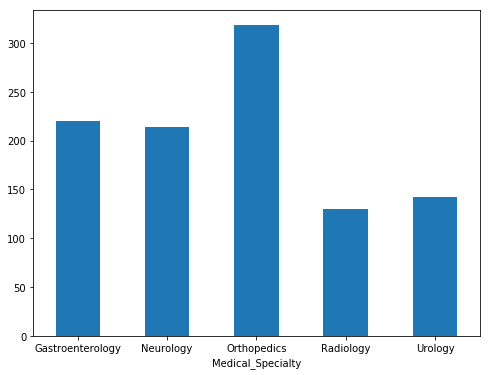

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,6))
df.groupby('Medical_Specialty').Medical_Notes.count().plot.bar(ylim=0)
plt.xticks(rotation=0)
plt.show()

In [16]:
# Our classes are reasonably balanced so we will leave them as is

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Add new stop words to the existing english stop words

my_stop_words = text.ENGLISH_STOP_WORDS.union(['preoperative', 'postoperative', 'diagnosis', 'procedure', 
                                               'anesthesia', 'indication', 'indications', 'findings', 'technique', 
                                              'cc', 'chief complaint', 'complaint', 'complains', 'hx', 'history', 
                                               'meds', 'medication', 'medications', 'pmh', 'prior medical history',
                                               'fhx', 'shx', 'exam', 'labs', 'course', 'complications', 'summary',
                                               'study', 'operation', 'performed', 'clinical', 'note', 'description'])

In [17]:
# Vectorize text with CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=my_stop_words, min_df = 5, max_df = .7)
df_countvectorize = vectorizer.fit_transform(df.Medical_Notes)
type(df_countvectorize)


/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['chief', 'medical', 'prior'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


scipy.sparse.csr.csr_matrix

In [18]:
df_countvectorize.shape

(1024, 11627)

In [19]:
# Try using TF-IDF Vectorizer
# sublinear_df is set to True to use a logarithmic form for frequency

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 3), stop_words=my_stop_words)
features = tfidf.fit_transform(df.Medical_Notes).toarray()
labels = df.specialty_id
features.shape

(1024, 11628)

In [20]:
# Find the terms that are the most correlated with each of the medical specialties:

from sklearn.feature_selection import chi2

N = 2

for Medical_Specialty, specialty_id in sorted(specialty_to_id.items()):
    features_chi2 = chi2(features, labels == specialty_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Medical_Specialty))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Gastroenterology':
  . Most correlated unigrams:
. colonoscopy
. colon
  . Most correlated bigrams:
. sigmoid colon
. abdominal pain
# 'Neurology':
  . Most correlated unigrams:
. temporal
. brain
  . Most correlated bigrams:
. plantar responses
. mri brain
# 'Orthopedics':
  . Most correlated unigrams:
. joint
. tourniquet
  . Most correlated bigrams:
. range motion
. extremity prepped
# 'Radiology':
  . Most correlated unigrams:
. fraction
. fetal
  . Most correlated bigrams:
. weeks days
. ejection fraction
# 'Urology':
  . Most correlated unigrams:
. urethra
. penis
  . Most correlated bigrams:
. external oblique
. bladder neck


In [39]:
# Create a dataframe of 5-fold CV metric scores for accuracy, precision, recall, and f1

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

models = [
    LinearSVC(),
    LogisticRegression(random_state=42),
    MultinomialNB(),
    RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
accuracy_entries = []
precision_entries = []
recall_entries = []
f1_entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    precisions = cross_val_score(model, features, labels, scoring='precision_weighted', cv=CV)
    recalls = cross_val_score(model, features, labels, scoring='recall_weighted', cv=CV)
    f1s = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)

    for fold_idx, accuracy in enumerate(accuracies):
        accuracy_entries.append((model_name, fold_idx, accuracy))
        
    for fold_idx, precision in enumerate(precisions):
        precision_entries.append((model_name, fold_idx, precision))
        
    for fold_idx, recall in enumerate(recalls):
        recall_entries.append((model_name, fold_idx, recall))

    for fold_idx, f1 in enumerate(f1s):
        f1_entries.append((model_name, fold_idx, f1))
        
accuracy_df = pd.DataFrame(accuracy_entries, columns=['model_name', 'fold_idx', 'accuracy'])
precision_df = pd.DataFrame(precision_entries, columns=['model_name', 'fold_idx', 'precision_weighted'])
recall_df = pd.DataFrame(recall_entries, columns=['model_name', 'fold_idx', 'recall_weighted'])
f1_df = pd.DataFrame(f1_entries, columns=['model_name', 'fold_idx', 'f1_weighted'])

cv_df = accuracy_df.merge(precision_df, left_on=['model_name', 'fold_idx'], right_on=['model_name', 'fold_idx'])
cv_df = cv_df.merge(recall_df, left_on=['model_name', 'fold_idx'], right_on=['model_name', 'fold_idx'])
cv_df = cv_df.merge(f1_df, left_on=['model_name', 'fold_idx'], right_on=['model_name', 'fold_idx'])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
cv_df

,model_name,fold_idx,accuracy,precision_weighted,recall_weighted,f1_weighted
0,LinearSVC,0,0.961165,0.961939,0.961165,0.960912
1,LinearSVC,1,0.902913,0.902841,0.902913,0.902706
2,LinearSVC,2,0.858537,0.876914,0.858537,0.856221
3,LinearSVC,3,0.931373,0.932652,0.931373,0.931218
4,LinearSVC,4,0.926108,0.931256,0.926108,0.924902
5,LogisticRegression,0,0.902913,0.916133,0.902913,0.902813
6,LogisticRegression,1,0.864078,0.868701,0.864078,0.862998
7,LogisticRegression,2,0.829268,0.851870,0.829268,0.823437
8,LogisticRegression,3,0.892157,0.894734,0.892157,0.890896
9,LogisticRegression,4,0.852217,0.869782,0.852217,0.849854


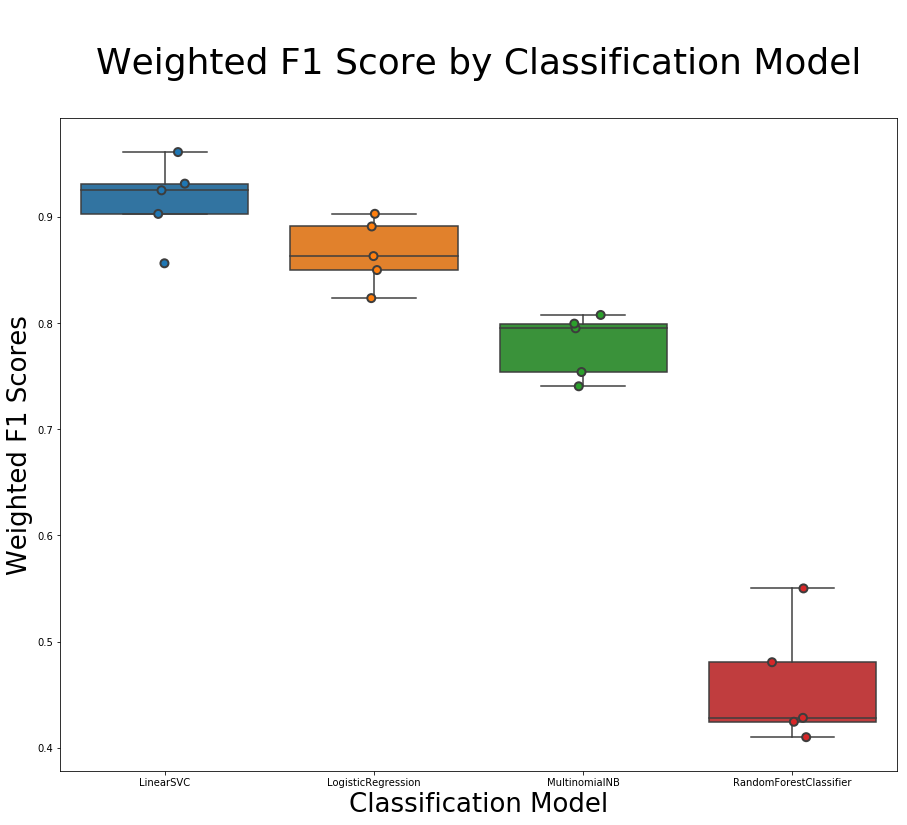

In [49]:
# Compare average weighted F1 scores for each model

import seaborn as sns

fig, ax = plt.subplots(figsize=(15,12))
sns.boxplot(x='model_name', y='f1_weighted', data=cv_df)
sns.stripplot(x='model_name', y='f1_weighted', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xlabel('Classification Model', fontsize=26)
plt.ylabel('Weighted F1 Scores', fontsize=26)
plt.title("""
Weighted F1 Score by Classification Model
""", fontsize=36)
plt.show()

In [24]:
# Let's see which model has the highest mean f1 score across folds

cv_df.groupby('model_name').f1_weighted.mean()

model_name
LinearSVC                 0.915192
LogisticRegression        0.866000
MultinomialNB             0.779270
RandomForestClassifier    0.458799
Name: f1_weighted, dtype: float64

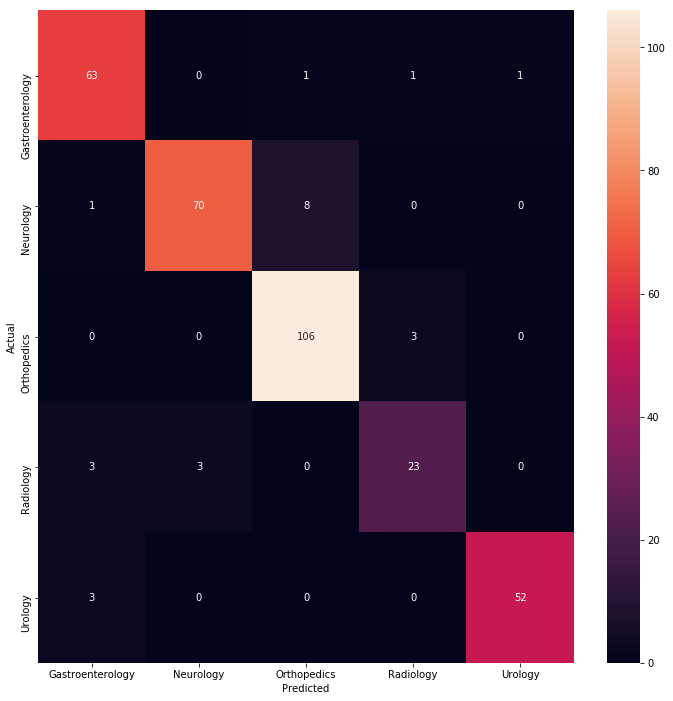

In [25]:
# Create a confusion matrix for the Linear SVC model

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, 
                                                                                 test_size=0.33, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=specialty_id_df.Medical_Specialty.values, 
            yticklabels=specialty_id_df.Medical_Specialty.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [26]:
# Print the top unigrams and bigrams for each medical specialty

model.fit(features, labels)
N = 2

for Medical_Specialty, specialty_id in sorted(specialty_to_id.items()):
    indices = np.argsort(model.coef_[specialty_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Medical_Specialty))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Gastroenterology':
  . Top unigrams:
       . abdominal
       . abdomen
  . Top bigrams:
       . abdominal pain
       . umbilical hernia
# 'Neurology':
  . Top unigrams:
       . temporal
       . brain
  . Top bigrams:
       . central canal
       . temporal artery
# 'Orthopedics':
  . Top unigrams:
       . joint
       . fracture
  . Top bigrams:
       . view right
       . range motion
# 'Radiology':
  . Top unigrams:
       . image
       . impression
  . Top bigrams:
       . measure cm
       . weeks days
# 'Urology':
  . Top unigrams:
       . prostate
       . penis
  . Top bigrams:
       . inguinal hernia
       . external oblique


In [27]:
# Linear SVC Metrics by Medical Specialty

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, 
                                                                                 test_size=0.33, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn import metrics

# The reported averages include micro average (averaging the total true positives, false negatives and false 
# positives), macro average (averaging the unweighted mean per label), weighted average (averaging the 
# support-weighted mean per label) and sample average (only for multilabel classification)

# Support is the number of actual occurrences of the class in the specified dataset

print(metrics.classification_report(y_test, y_pred, target_names=df['Medical_Specialty'].unique()))

                  precision    recall  f1-score   support

Gastroenterology       0.90      0.95      0.93        66
       Neurology       0.96      0.89      0.92        79
     Orthopedics       0.92      0.97      0.95       109
       Radiology       0.85      0.79      0.82        29
         Urology       0.98      0.95      0.96        55

       micro avg       0.93      0.93      0.93       338
       macro avg       0.92      0.91      0.92       338
    weighted avg       0.93      0.93      0.93       338



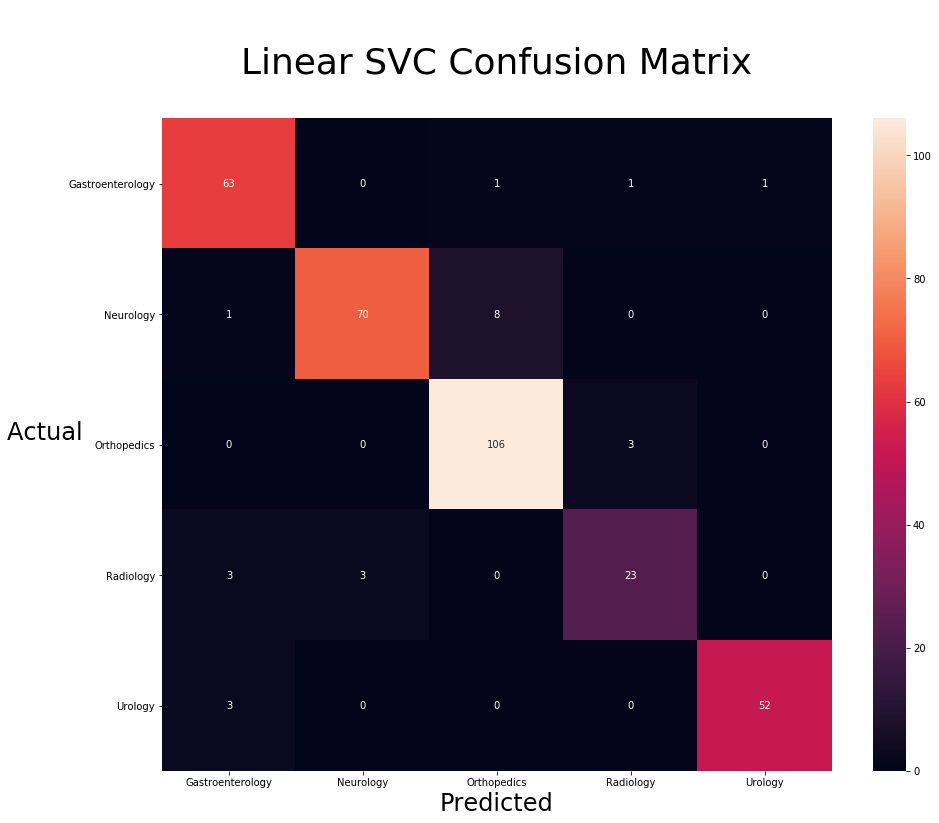

In [28]:
# Create a confusion matrix for the Linear SVC model

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=specialty_id_df.Medical_Specialty.values, 
            yticklabels=specialty_id_df.Medical_Specialty.values)
plt.xlabel('Predicted', fontsize=24)
plt.ylabel('Actual     ', fontsize=24, rotation=0)
plt.yticks(rotation=0)
plt.title("""
Linear SVC Confusion Matrix
""", fontsize=36)
plt.show();

In [29]:
# Logistic Regression Metrics by Medical Specialty

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred, target_names=df['Medical_Specialty'].unique()))

                  precision    recall  f1-score   support

Gastroenterology       0.83      0.94      0.88        66
       Neurology       0.96      0.81      0.88        79
     Orthopedics       0.83      0.96      0.89       109
       Radiology       0.93      0.86      0.89        29
         Urology       0.98      0.76      0.86        55

       micro avg       0.88      0.88      0.88       338
       macro avg       0.90      0.87      0.88       338
    weighted avg       0.89      0.88      0.88       338



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


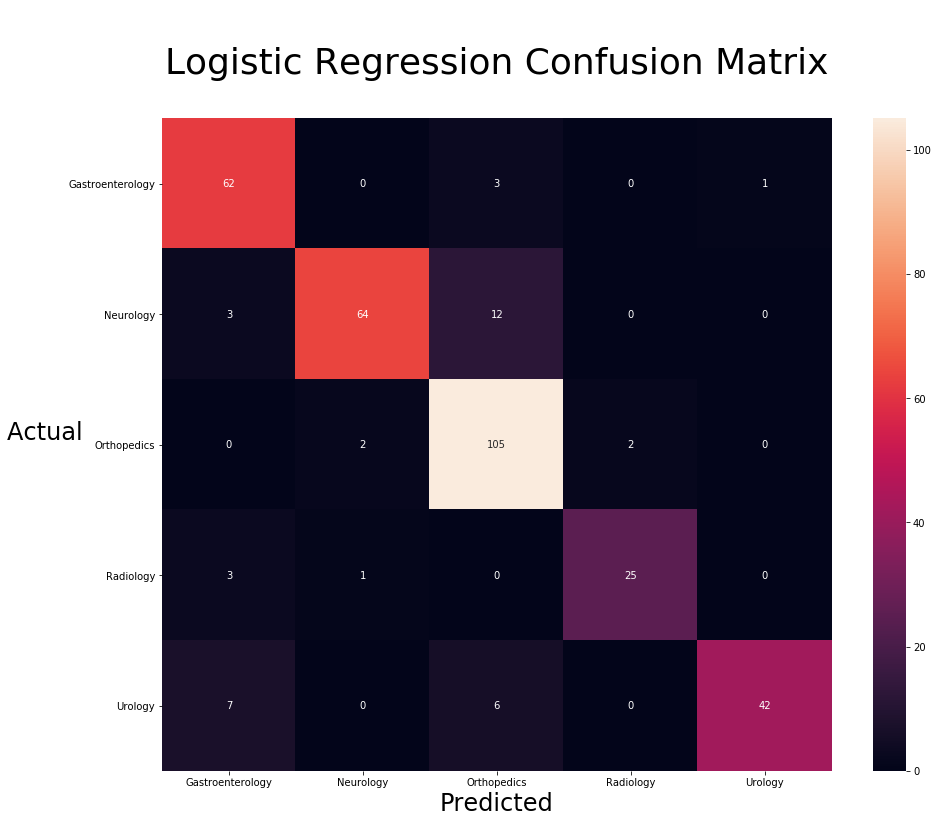

In [30]:
# Create a confusion matrix for the Logistic Regression model

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=specialty_id_df.Medical_Specialty.values, 
            yticklabels=specialty_id_df.Medical_Specialty.values)
plt.xlabel('Predicted', fontsize=24)
plt.ylabel('Actual     ', fontsize=24, rotation=0)
plt.yticks(rotation=0)
plt.title("""
Logistic Regression Confusion Matrix
""", fontsize=36)
plt.show();

In [31]:
# Multinomial Naive Bayes Metrics by Medical Specialty

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred, target_names=df['Medical_Specialty'].unique()))

                  precision    recall  f1-score   support

Gastroenterology       0.74      0.89      0.81        66
       Neurology       0.93      0.80      0.86        79
     Orthopedics       0.73      0.96      0.83       109
       Radiology       0.96      0.79      0.87        29
         Urology       1.00      0.40      0.57        55

       micro avg       0.80      0.80      0.80       338
       macro avg       0.87      0.77      0.79       338
    weighted avg       0.84      0.80      0.79       338



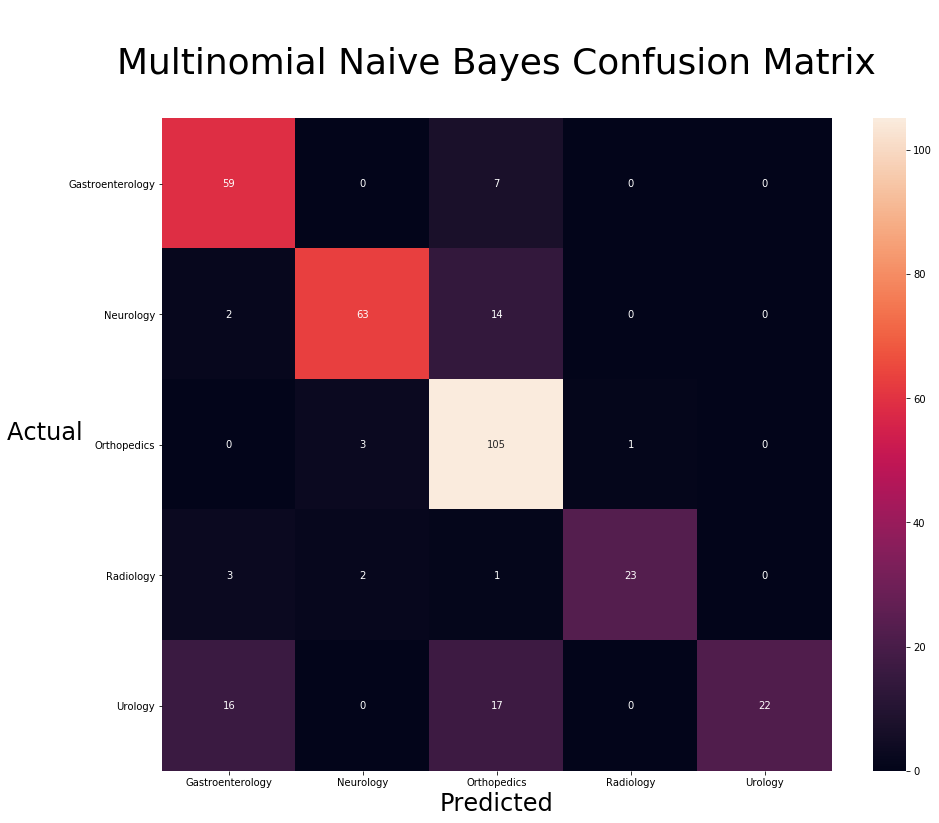

In [32]:
# Create a confusion matrix for the Multinomial Naive Bayes model

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=specialty_id_df.Medical_Specialty.values, 
            yticklabels=specialty_id_df.Medical_Specialty.values)
plt.xlabel('Predicted', fontsize=24)
plt.ylabel('Actual     ', fontsize=24, rotation=0)
plt.yticks(rotation=0)
plt.title("""
Multinomial Naive Bayes Confusion Matrix
""", fontsize=36)
plt.show();

In [33]:
# Random Forest Metrics by Medical Specialty

model = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred, target_names=df['Medical_Specialty'].unique()))

                  precision    recall  f1-score   support

Gastroenterology       0.45      0.55      0.49        66
       Neurology       0.82      0.52      0.64        79
     Orthopedics       0.54      0.91      0.67       109
       Radiology       0.76      0.45      0.57        29
         Urology       0.67      0.07      0.13        55

       micro avg       0.57      0.57      0.57       338
       macro avg       0.65      0.50      0.50       338
    weighted avg       0.63      0.57      0.53       338



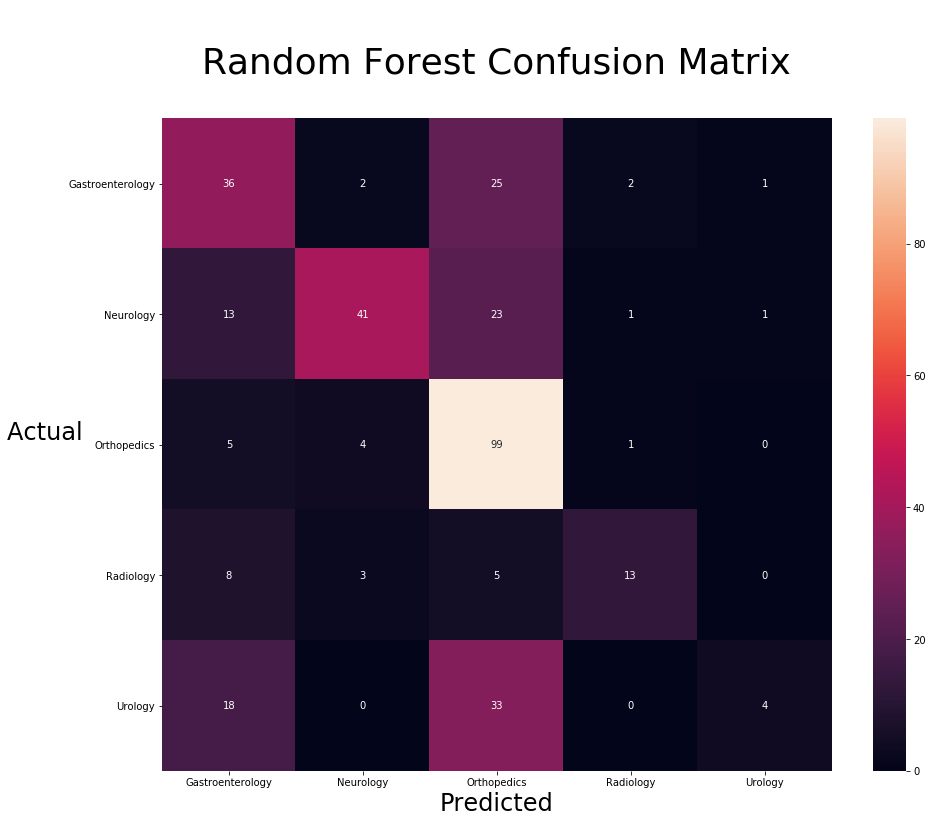

In [34]:
# Create a confusion matrix for the Random Forest model

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=specialty_id_df.Medical_Specialty.values, 
            yticklabels=specialty_id_df.Medical_Specialty.values)
plt.xlabel('Predicted', fontsize=24)
plt.ylabel('Actual     ', fontsize=24, rotation=0)
plt.yticks(rotation=0)
plt.title("""
Random Forest Confusion Matrix
""", fontsize=36)
plt.show();